
In the third and final installment of the *Up and Running with JAX* series, we demonstrate the remaining steps required to train and evaluate a simple neural network, specifically 
the implementation of the loss function, backward pass and training loop. As in Part 2, the focus will be on predicting class labels for the MNIST dataset, which consists of 28x28 pixel images of handwritten digits (0-9). The training loop consists of the following steps:

- Load a batch of training data.
- Obtain model predictions for current batch of images.
- Calculate the loss for current batch predictions vs. targets.
- Calculate backward gradients over the weights and biases.
- Update the weights and biases using the gradient information.
- Calculate the loss on a set of images not used for training.


We begin by loading the dataset and functions implemented in Part 2 that facilitate weight initialization and the network forward pass: 

In [1]:

import warnings

import numpy as np
import pandas as pd

import torch
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.transforms import v2
import matplotlib.pyplot as plt

np.set_printoptions(suppress=True, precision=5, linewidth=1000)
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option("display.precision", 5)
warnings.filterwarnings("ignore")

# Batch size.
bs = 64

train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=v2.Compose([ToTensor()])
)

valid_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=v2.Compose([ToTensor()])
)

# Convert PIL images to NumPy arrays.
train_data_arr = train_data.data.numpy() / 255.0      # Normalize pixel values to [0, 1]
valid_data_arr = valid_data.data.numpy() / 255.0      # Normalize pixel values to [0, 1] 
train_data_arr = train_data_arr.reshape(-1, 28 * 28)  # Flatten images to 1D arrays
valid_data_arr = valid_data_arr.reshape(-1, 28 * 28)  # Flatten images to 1D arrays
train_labels = train_data.targets.numpy()
valid_labels = valid_data.targets.numpy()

# Create training and validation batches of 64.
train_batches = [
    (train_data_arr[(bs * ii):(bs * (ii + 1))], train_labels[(bs * ii):(bs * (ii + 1))]) 
    for ii in range(len(train_data_arr) // bs)
]
valid_batches = [
    (valid_data_arr[(bs * ii):(bs * (ii + 1))], valid_labels[(bs * ii):(bs * (ii + 1))]) 
    for ii in range(len(valid_data_arr) // bs)
]

print(f"train_data_arr.shape: {train_data_arr.shape}")
print(f"valid_data_arr.shape: {valid_data_arr.shape}")
print(f"train_labels.shape  : {train_labels.shape}")
print(f"valid_labels.shape  : {valid_labels.shape}")
print(f"len(train_batches)  : {len(train_batches)}")
print(f"len(valid_batches)  : {len(valid_batches)}")


train_data_arr.shape: (60000, 784)
valid_data_arr.shape: (10000, 784)
train_labels.shape  : (60000,)
valid_labels.shape  : (10000,)
len(train_batches)  : 937
len(valid_batches)  : 156


In [2]:
"""
Functions introduced in Part 2. Refer to 

    https://www.jtrive.com/posts/intro-to-jax-part-2/intro-to-jax-part-2.html

for more information. 
"""
from jax import random, vmap
import jax.numpy as jnp
from jax.nn import relu


def initialize_weights(sizes, key, scale=.02):
    """
    "Initialize weights and biases for each layer for simple fully-connected 
    network.

    Parameters
    ----------
    sizes : list of int
        List of integers representing the number of neurons in each layer.

    key : jax.random.PRNGKey
        Random key for JAX.

    Returns
    -------
    List of initialized weights and biases for each layer.
    """
    keys = random.split(key, len(sizes) - 1)
    params = []
    for m, n, k in zip(sizes[:-1], sizes[1:], keys):
        w_key, b_key = random.split(k)
        w = scale * random.normal(w_key, (m, n))
        b = scale * random.normal(b_key, (n,))
        params.append((w, b))
    return params


def forward(params, X):
    """
    Forward pass for simple fully-connected network.

    Parameters
    ----------
    params : list of tuples
        List of tuples containing weights and biases for each layer.

    X : jax.numpy.ndarray
        Input data.

    Returns
    -------
    jax.numpy.ndarray
    """
    a = X
    for W, b in params[:-1]:
        z = jnp.dot(a, W) + b
        a = relu(z)
    W, b = params[-1]
    return jnp.dot(a, W) + b


# Auto-vectorization of forward pass.
batch_forward = vmap(forward, in_axes=(None, 0))



<br>

### **Cross-Entropy Loss and Softmax**

Categorical cross-entropy loss is the most commonly used loss function for multi-class classification with mutually-exclusive classes. A lower cross-entropy loss means the predicted probabilities are closer to the true labels. A key characteristic of cross entropy loss is that it rewards/penalizes the probabilities of correct classes only: The value is independent of how the remaining probability is split between the incorrect classes. 

For a single sample with \( C \) classes, the cross-entropy loss is give by

$$
L = - \frac{1}{n}\sum_{i=1}^{C} y_i \times \log(\hat{y_i}),
$$

where:
- $n$ is the batch size.
- $y_i$ is the true label (1 for the correct class, 0 otherwise).
- $\hat{y_i}$ is the predicted probability for class $i$ (from softmax).
- The $\log$ ensures the loss is large when the predicted probability is low for the correct class.


If we had a single vector of actual labels representing the index of the correct class (i.e., `yact` from above), simply compute the negative log of the probability at this index to get the cross entropy loss for that sample (since cross-entropy doesn't consider incorrect classes).

We forego one-hot encoding our targets, so our loss function accepts a batch of final layer activations (`logits`) and targets (`labels`) represented as a single integer between 0 and 9 per sample. Using a batch size of 64, `logits` has shape (64, 10), and `labels` (64,):

In [3]:

from jax.nn import log_softmax


def cross_entropy_loss(params, X, y):
    """
    Compute the loss for the given logits and labels.

    Parameters
    ----------
    params : list of tuples
        List of tuples containing weights and biases for each layer.

    logits :
        Batch of final layer activations.

    labels :
        Batch of true labels, a single integer per sample.
   
    Returns
    -------
    Computed loss.
    """
    # Compute logits for the batch.
    logits = forward(params, X)

    # Convert logits to log probabilities.
    log_probs = log_softmax(logits)

    return -log_probs[jnp.arange(len(y)), y].mean()



<br>

The softmax function converts a vector logits into a probability distribution over classes. Logits refer to the raw, unnormalized output values produced by the last layer of a neural network before applying an activation function. It is commonly used in classification tasks. In some deep learning frameworks, cross-entropy loss is combined with softmax within a single function (see for example, [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) in PyTorch). For a vector $z$ of length $n$, softmax is defined as:

$$
\sigma(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{n} e^{z_j}},
$$

where:

- $e^{z_i}$ exponentiates each element.
- The denominator ensures all probabilities sum to 1.

<br>


If any of the $z_i$ is large, $e^{z_i}$ can become extremely large, potentially causing overflow errors in computation. For example:

```python
import numpy as np

z = np.array([1000, 2000, 3000])         # Large values
softmax = np.exp(z) / np.sum(np.exp(z))  # OverflowError
```

<br>

Since $e^{3000}$ is astronomically large, Python will struggle to handle it. The solution is to subtract the max value
of each sample instead of using $z$ directly:

$$
\sigma(z_i) = \frac{e^{z_i - \max(z)}}{\sum_{j=1}^{n} e^{z_j - \max(z)}}
$$

<br>

This shifts all values down without affecting the final probabilities (since shifting inside the exponent maintains relative differences).

<br>


### **Backward Pass**


In order to obtain the gradients of the loss function w.r.t. the model parameters, JAX's `grad` function can be used. `grad` computes the gradient of a scalar-valued function with respect to its inputs. It performs automatic differentiation by tracing the computation and building a backward pass to compute derivatives. `grad` accepts a Python function and returns a new function that computes the gradient of the original function. The returned function takes the same inputs as the original and returns the derivative w.r.t. the argument specified (the first argument by default).

Note that `grad` only returns the gradients of the loss function with respect to the parameters, and not the actual loss value. This is important information to have during training. We can instead use `value_and_grad`, which returns the actual loss value along with the gradients as a tuple. In the next cell, `update` implements the gradient update. I've included an `accuracy` function, which is used to evaluate model performance after each epoch:

In [4]:

from jax import value_and_grad


def update(params, X, y, lr=.01):
    """
    Update weights and biases using gradient descent.

    Parameters
    ----------
    params : list of tuples
        List of tuples containing weights and biases for each layer.

    X : jax.numpy.ndarray
        Input data.

    y : jax.numpy.ndarray
        True labels.

    lr : float
        Learning rate.

    Returns
    -------
    tuple
        Updated weights and biases.
    """
    # Compute loss and gradients.
    loss, grads = value_and_grad(cross_entropy_loss)(params, X, y)
    
    # Unpack parameters and gradients.
    (W1, b1), (W2, b2) = params
    (dW1, db1), (dW2, db2) = grads

    # Update weights and biases.
    W1_new = W1 - lr * dW1
    b1_new = b1 - lr * db1
    W2_new = W2 - lr * dW2
    b2_new = b2 - lr * db2
    
    return [(W1_new, b1_new), (W2_new, b2_new)], loss



def accuracy(logits, labels):
    """
    Compute accuracy.

    Parameters
    ----------
    logits : jax.numpy.ndarray
        Final layer activations.

    labels : jax.numpy.ndarray
        True labels.

    Returns
    -------
    float
        Accuracy.
    """
    preds = jnp.argmax(logits, axis=1)
    return (preds == labels).mean()



<br>
We have everything setup train the network. The training loop is provided in the next cell, where the network is trained for 25 epochs:


In [ ]:

from time import perf_counter

# Layer sizes.
sizes = [784, 128, 10]

# Number of epochs.
n_epochs = 25

# Learning rate.
lr = 0.01

# Store loss, accuracy and runtime.
results = []

# Initialize weights ands biases.
params = initialize_weights(sizes, key=random.PRNGKey(516), scale=.02)   

for epoch in range(n_epochs):

    start_time = perf_counter()

    losses = [] 

    for X, y in train_batches:
        # Compute loss.
        params, loss = update(params, X, y, lr=lr)
        losses.append(loss.item())

    epoch_time = perf_counter() - start_time
    avg_loss = np.mean(losses)
    train_acc = np.mean([accuracy(forward(params, X), y).item() for X, y in train_batches])
    valid_acc = np.mean([accuracy(forward(params, X), y).item() for X, y in valid_batches])
    results.append((epoch + 1, avg_loss, train_acc, valid_acc, epoch_time))
    print(f"Epoch {epoch + 1}/{n_epochs}: loss: {avg_loss:.4f}, train acc.: {train_acc:.3f}, valid acc.: {valid_acc:.3f}, time: {epoch_time:.2f} sec.")



Epoch 1/25: loss: 1.5768, train acc.: 0.818, valid acc.: 0.824, time: 11.59 sec.
Epoch 2/25: loss: 0.5859, train acc.: 0.873, valid acc.: 0.881, time: 11.40 sec.
Epoch 3/25: loss: 0.4297, train acc.: 0.891, valid acc.: 0.896, time: 15.88 sec.
Epoch 4/25: loss: 0.3753, train acc.: 0.899, valid acc.: 0.904, time: 12.13 sec.
Epoch 5/25: loss: 0.3464, train acc.: 0.905, valid acc.: 0.909, time: 13.94 sec.
Epoch 6/25: loss: 0.3270, train acc.: 0.909, valid acc.: 0.913, time: 14.45 sec.
Epoch 7/25: loss: 0.3123, train acc.: 0.913, valid acc.: 0.918, time: 13.47 sec.
Epoch 8/25: loss: 0.2999, train acc.: 0.916, valid acc.: 0.920, time: 13.78 sec.
Epoch 9/25: loss: 0.2891, train acc.: 0.919, valid acc.: 0.922, time: 13.89 sec.
Epoch 10/25: loss: 0.2792, train acc.: 0.922, valid acc.: 0.925, time: 13.20 sec.
Epoch 11/25: loss: 0.2699, train acc.: 0.925, valid acc.: 0.927, time: 13.02 sec.
Epoch 12/25: loss: 0.2611, train acc.: 0.927, valid acc.: 0.930, time: 13.94 sec.
Epoch 13/25: loss: 0.2529


<br>

The loss decreases as a function of epoch, and  the best validation accuracy was realized on the 25th epoch. We can visualize our training metrics:

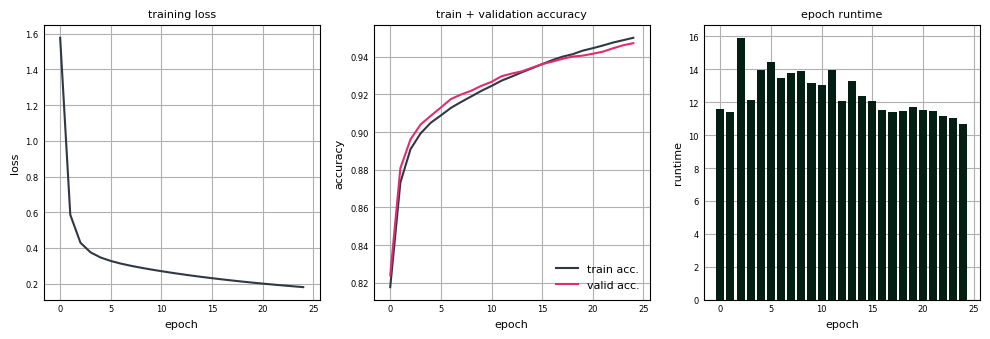

In [19]:

v_color = "#8fcdb5"
t_color = "#031f14"

# Unpack results list. 
_, loss, tacc, vacc, epoch_time = zip(*results)
xx = range(len(loss))

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5), sharex=True, tight_layout=True) 

# Training loss.
ax[0].set_title("training loss", fontsize=8)
ax[0].plot(xx, loss, color="#303846")
ax[0].set_xlabel("epoch", fontsize=8)
ax[0].set_ylabel("loss", fontsize=8)
#ax[0].set_xticks(xx)
ax[0].tick_params(axis="x", which="major", direction='in', labelsize=6)
ax[0].tick_params(axis="y", which="major", direction='in', labelsize=6)
ax[0].xaxis.set_ticks_position("none")
ax[0].yaxis.set_ticks_position("none")
ax[0].grid(True)
ax[0].set_axisbelow(True)

# Training and validation accuracy.
ax[1].set_title("train + validation accuracy", fontsize=8)
ax[1].plot(xx, tacc, color="#303846", label="train acc.")
ax[1].plot(xx, vacc, color="#E02C70", label="valid acc.")
ax[1].set_xlabel("epoch", fontsize=8)
ax[1].set_ylabel("accuracy", fontsize=8)
#ax[1].set_xticks(xx)
ax[1].tick_params(axis="x", which="major", direction='in', labelsize=6)
ax[1].tick_params(axis="y", which="major", direction='in', labelsize=6)
ax[1].xaxis.set_ticks_position("none")
ax[1].yaxis.set_ticks_position("none")
ax[1].grid(True)
ax[1].set_axisbelow(True)
ax[1].legend(loc="lower right", fontsize=8, frameon=False)

# Runtime.
ax[2].set_title("epoch runtime", fontsize=8)
ax[2].bar(xx, epoch_time, color=t_color)
ax[2].set_xlabel("epoch", fontsize=8)
ax[2].set_ylabel("runtime", fontsize=8)
#ax[2].set_xticks(xx)
ax[2].tick_params(axis="x", which="major", direction='in', labelsize=6)
ax[2].tick_params(axis="y", which="major", direction='in', labelsize=6)
ax[2].xaxis.set_ticks_position("none")
ax[2].yaxis.set_ticks_position("none")
ax[2].grid(True)
ax[2].set_axisbelow(True)

plt.show()




<br>

Given the shape of the training and validation accuracy curves, it's likely that the network still had room to improve, and with additional epochs would almost certainly have achieved even better performance.  

<br>

### **JIT Compilation**

On average, it took around 13 seconds for one full pass through the data using CPU. We can reduce the runtime drastically by just-in-time compiling the `update` function. Recall from the first installment of the series that Just-In-Time (JIT) compilation in JAX refers to the process of transforming a Python function into highly optimized, low-level code (usually XLA-compiled) that runs much faster. This can be accomplished using the `@jit` decorator. `update` now becomes: 

In [24]:

from jax import jit

@jit
def update(params, X, y, lr=.01):
    """
    Update weights and biases using gradient descent.

    Parameters
    ----------
    params : list of tuples
        List of tuples containing weights and biases for each layer.

    X : jax.numpy.ndarray
        Input data.

    y : jax.numpy.ndarray
        True labels.

    lr : float
        Learning rate.

    Returns
    -------
    tuple
        Updated weights and biases.
    """
    # Compute loss and gradients.
    loss, grads = value_and_grad(cross_entropy_loss)(params, X, y)
    
    # Unpack parameters and gradients.
    (W1, b1), (W2, b2) = params
    (dW1, db1), (dW2, db2) = grads

    # Update weights and biases.
    W1_new = W1 - lr * dW1
    b1_new = b1 - lr * db1
    W2_new = W2 - lr * dW2
    b2_new = b2 - lr * db2
    
    return [(W1_new, b1_new), (W2_new, b2_new)], loss



<br>

 Let's retrain the network and assess the impact JIT compilation has on per-epoch training time:

In [25]:
"""
Same training loop as before, but now using JIT compilation.
"""

from time import perf_counter

# Layer sizes.
sizes = [784, 128, 10]

# Number of epochs.
n_epochs = 25

# Learning rate.
lr = 0.01

# Store loss, accuracy and runtime.
results = []

# Initialize weights ands biases.
params = initialize_weights(sizes, key=random.PRNGKey(516), scale=.02)   

for epoch in range(n_epochs):

    start_time = perf_counter()

    losses = [] 

    for X, y in train_batches:
        # Compute loss.
        params, loss = update(params, X, y, lr=lr)
        losses.append(loss.item())

    epoch_time = perf_counter() - start_time
    avg_loss = np.mean(losses)
    train_acc = np.mean([accuracy(forward(params, X), y).item() for X, y in train_batches])
    valid_acc = np.mean([accuracy(forward(params, X), y).item() for X, y in valid_batches])
    results.append((epoch + 1, avg_loss, train_acc, valid_acc, epoch_time))
    print(f"Epoch {epoch + 1}/{n_epochs}: loss: {avg_loss:.4f}, train acc.: {train_acc:.3f}, valid acc.: {valid_acc:.3f}, time: {epoch_time:.2f} sec.")



Epoch 1/25: loss: 1.5768, train acc.: 0.818, valid acc.: 0.824, time: 1.20 sec.
Epoch 2/25: loss: 0.5859, train acc.: 0.873, valid acc.: 0.881, time: 0.85 sec.
Epoch 3/25: loss: 0.4297, train acc.: 0.891, valid acc.: 0.896, time: 0.84 sec.
Epoch 4/25: loss: 0.3753, train acc.: 0.899, valid acc.: 0.904, time: 0.83 sec.
Epoch 5/25: loss: 0.3464, train acc.: 0.905, valid acc.: 0.909, time: 0.82 sec.
Epoch 6/25: loss: 0.3270, train acc.: 0.909, valid acc.: 0.913, time: 0.84 sec.
Epoch 7/25: loss: 0.3123, train acc.: 0.913, valid acc.: 0.918, time: 0.85 sec.
Epoch 8/25: loss: 0.2999, train acc.: 0.916, valid acc.: 0.920, time: 0.83 sec.
Epoch 9/25: loss: 0.2891, train acc.: 0.919, valid acc.: 0.922, time: 0.83 sec.
Epoch 10/25: loss: 0.2792, train acc.: 0.922, valid acc.: 0.925, time: 0.82 sec.
Epoch 11/25: loss: 0.2699, train acc.: 0.924, valid acc.: 0.927, time: 0.85 sec.
Epoch 12/25: loss: 0.2611, train acc.: 0.927, valid acc.: 0.930, time: 0.87 sec.
Epoch 13/25: loss: 0.2529, train acc.


<br>

By simply adding the `jit` decorator to the `update` function, the average training time per epoch dropped from around 13 seconds to under a second, with no degradation of performance. Pretty remarkable!

<br>

### **Conclusion**

JAX is a powerful tool for deep learning because it combines NumPy-like syntax with automatic differentiation, just-in-time (JIT) compilation for performance, and seamless GPU/TPU support, all while enabling functional programming patterns that make complex model transformations and optimization easier to express. In this series, we've only scratched the surface of what's possible with JAX. For those eager to explore further, I recommend *Deep Learning with JAX* by Grigory Sapunov, which dives into more advanced topics and real-world applications of the framework.

I'm currently spending time getting familiar with [Flax](https://flax.readthedocs.io/en/latest/), a powerful, higher-level deep learning library that makes it easier to define, train, and manage models without sacrificing flexibility or performance (you can think of JAX as the engine and Flax as the framework that helps you build with that engine). It offers tools to define neural networks, handle parameter initialization and state management, and integrates nicely with JAX's functional approach. It's designed to make building and training deep learning models easier and more scalable without hiding the JAX underpinnings. More on Flax in a future post. 



<br>

